<a href="https://colab.research.google.com/github/adarsh1chand/Quantum-Reservoir_Computing/blob/main/Quantum_Reservoir_Computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Reservoir Computing (Exploratory notebook using Pennylane)

In [1]:
# requirements
!pip install --quiet pennylane


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 41.6 MB/s eta 0:00:00


In [2]:
# Added to silence some warnings.
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import pennylane as qml

import pennylane.numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from copy import deepcopy
import random

# Set the seed
np.random.seed(42)

### Generating synthetic time-series data to play-around

In [3]:
def generate_synthetic_time_series_data(num_data_points: int = 2060,
                                        random_fluctuation_scale: float = 1.0,
                                        start_date: str = '2017-11-08'):
    """Generate synthetic time-series data"""

    dates = pd.date_range(start = start_date, periods = num_data_points)
    values = np.random.randn(num_data_points).cumsum() + random_fluctuation_scale * np.random.rand()
    return dates, values


def batch_time_series_data(data: np.array = None,
                           num_data_points:int = 2060,
                           time_window: int = 60):
    if data is None:
        dates, values = generate_synthetic_time_series_data(num_data_points)

    dates, values = data

    idx = 0
    batched_history = []
    ground_truth_values = []
    while idx + time_window < len(dates):
        batched_history.append(values[idx: idx + time_window])
        ground_truth_values.append((dates[idx + time_window], values[idx + time_window]))
        idx += 1

    return batched_history, ground_truth_values



def plot_time_series(dates,
                     values,
                     xlabel: str = 'Date',
                     ylabel: str = 'Value',
                     title: str = 'Synthetic time-series data'):

    """Plot the time-series data"""
    plt.plot(dates, values)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.xticks(rotation = 45)
    plt.title('Synthetic time-series data')
    plt.show()

def normalize(values: np.array):
    """Normalize all values in an array with mean 0 and standard deviation of 1."""

    values = deepcopy(values)
    return (values - np.mean(values)) / np.std(values)

def scale(values: np.array):
    """Scale all values in an array between 0 and 1"""

    values = deepcopy(values)
    max_abs_value = max([abs(val) for val in values])
    values = values / max_abs_value

    # Check if minimum value in the values is less than zero
    if min(values) < 0:
      # change the scale from [-1, 1] to [0, 1]
      return (1 + values) / 2

    # Else just return the values
      return values

def normalize_and_scale(values: np.array):
    """Normalize and scale all the values in an array."""

    values = deepcopy(values)
    values = normalize(values)
    return scale(values)

def shuffle_data(X, y):
    """Shuffle the batches of time series data"""
    X = deepcopy(X)
    y = deepcopy(y)

    combined_data = list(zip(X, y))
    random.shuffle(combined_data)
    X, y = zip(*combined_data)
    X = list(X)

    return X, y

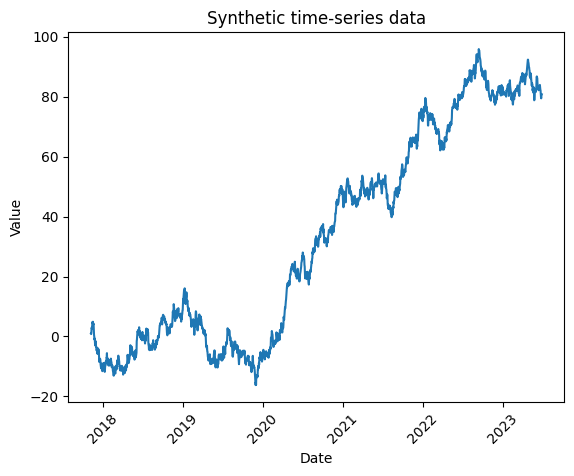

In [4]:
dates, values = generate_synthetic_time_series_data()
plot_time_series(dates, values)

In [5]:
values = normalize_and_scale(values)
history, truths = batch_time_series_data((dates, values))
batched_history, ground_truths = shuffle_data(history, truths)

ground_truth_dates = []
truth_dates = []
ground_truth_values = []
truth_values = []
for date, value in ground_truths:
    ground_truth_dates.append(date)
    ground_truth_values.append(value)

for date, value in truths:
    truth_dates.append(date)
    truth_values.append(value)

print(len(batched_history))
print(batched_history[0].shape)
print(len(ground_truth_values))

2000
(60,)
2000


In [6]:
# Check sample data from the dataset
idx = 78
print(batched_history[idx])
print(ground_truth_values[idx])

[0.90369957 0.90634419 0.90786175 0.91351338 0.91004421 0.91413171
 0.91206411 0.91794962 0.92285176 0.91539987 0.92405102 0.91978143
 0.92621857 0.92914445 0.94378778 0.94200761 0.93922488 0.93907018
 0.93665499 0.94302749 0.93015164 0.9217578  0.91325148 0.92082181
 0.93444889 0.93361683 0.93227196 0.93283001 0.94208576 0.93469828
 0.93659718 0.94436579 0.9483576  0.94986785 0.95784238 0.9363079
 0.94170799 0.9364975  0.92191432 0.92598666 0.93692949 0.93583455
 0.94342533 0.95626905 0.96674392 0.97980819 0.98572012 0.98632104
 0.97355947 0.97159929 0.96488182 0.98217598 0.98077484 0.98175631
 0.98614955 0.98649689 1.         0.99503985 0.99659014 0.99067547]
0.9801599142535422


### Constructing the Quantum Reservoir
We will consider the Ising Hamiltonian with only $X-X$ type interactions between all the qubits as our quantum reservoir, i.e. the Hamiltonian looks like:
$$
\begin{align}
    &\hat{H} = h\sum_{i = 0}^{N}\sigma_{z}^{(i)} + \sum_{i \neq j}J_{ij}\sigma_{x}^{(i)}\sigma_{x}^{(j)}
\end{align}
$$

where, $N$ is the number of qubits in the spin glass system, $2h$ is the single-qubit energy which is same for all qubits and $J_{ij}$ is the coupling strength of the $X-X$ interaction between qubits $i$ and $j$.


In [7]:
N = 3 # Number of qubits in the spin glass system
single_qubit_energy = 1  # single qubit energy in the excited state.

coupling_matrix = np.random.rand(N, N) # Matrix containing the coupling constants between the qubits of the X-X type interaction terms
coupling_matrix = 1 - (np.transpose(coupling_matrix) + coupling_matrix)   # Making the coupling matrix symmetric and values between [-1, 1]
for i in range(N):          # Setting the diagonal terms to zero in the coupling matrix
  coupling_matrix[i, i] = 0.0

In [8]:
initial_eigen_values, initial_eigen_vector_matrix = np.linalg.eigh(coupling_matrix)  # Eigenvalues and eigenvectors of the copuling matrix
initial_J_0 = max([abs(eigval) for eigval in initial_eigen_values]) # Maximum absolute value of all the eigenvalues of the coupling matrix
                                                                    # (The spectral radius of the coupling or the coupling strength)
single_qubit_coefficients = [0.5 * single_qubit_energy] * N
single_qubit_observables = [qml.PauliZ(i) for i in range(N)]

coupling_matrix_triu = np.triu(coupling_matrix, k = 1)
interaction_coefficients =  list(2 * np.array(coupling_matrix_triu[np.triu(np.ones(coupling_matrix_triu.shape), k=1).astype(bool)].tolist()))
interaction_observables = []

for i in range(N):
  for j in range(N):
    if i < j:
      interaction_observables.append(qml.PauliX(i) @ qml.PauliX(j))

In [9]:
# Forming the spin-glass Hamiltonian operator (Quantum reservoir operator)
reservoir_hamiltonian = qml.Hamiltonian(single_qubit_coefficients + interaction_coefficients, single_qubit_observables + interaction_observables)
print(reservoir_hamiltonian)

  (0.5) [Z0]
+ (0.5) [Z1]
+ (0.5) [Z2]
+ (-0.7034544438915105) [X0 X2]
+ (-0.25305183841105894) [X1 X2]
+ (1.0667848430224685) [X0 X1]


### Data pre-processing
We will normalize and scale all the values in the time-series data between [0, 1] so that the values can be loaded into the quantum state of input qubit.

The input state to the reservoir is provided after every $T$ time steps and the loading of the input can be represented by the Completely Positive-Trace Preserving (CPTP) map as follows:
$$
\begin{align}
  \rho \rightarrow |\psi_{s_{k}}\rangle\langle\psi_{s_{k}}| \otimes \text{Tr}_{1}[\rho]
\end{align}
$$

In [10]:
def prepare_input_state_matrix(s_k: float,
                        partial_rho: np.array = None):
  """
  Function which calculates the density in which the input register needs to be prepared.
  """

  if partial_rho is None:
    partial_rho = np.zeros(shape = (2 ** (N - 1), 2 ** (N - 1)))
    partial_rho[0, 0] = 1

  input_state_vector = np.array([[np.sqrt(1 - s_k)], [np.sqrt(s_k)]])
  first_qubit_density_matrix = np.kron(input_state_vector, np.transpose(input_state_vector))
  return np.kron(first_qubit_density_matrix, partial_rho)

def prepare_input_state(s_k: float,
                              partial_rho: np.array = None):
  """"Prepares the input register by loading the value at instant 'k', i.e. s_k into the
      the first qubit and initializing the rest of the qubits in the state $\text{Tr}_{1}[\rho]
      which is just the density matrix obtained from previous iteration's ((k-1) instant) of the
      reservoir evolution and tracing out the first qubit.
  """

  qml.QubitDensityMatrix(prepare_input_state_matrix(s_k, partial_rho), wires = range(N))


In [11]:
dev = qml.device("default.mixed", wires = N)

@qml.qnode(dev)
def reservoir_computation(s_k: float,
                          reduced_density_matrix: np.array,
                          evolution_time: float,
                          readout = False):

  prepare_input_state(s_k, reduced_density_matrix)
  qml.ApproxTimeEvolution(reservoir_hamiltonian, time = evolution_time, n = 12)
  if readout:
    return np.array([qml.expval(qml.PauliZ(i)) for i in range(N)])
  else:
    return qml.density_matrix(range(1, N))


In [12]:
def reservoir_forward(s_k,
            input_time = 1,
            readout_time = 1,
            reduced_density_matrix = None
            ):

  reservoir_outputs = []


  # Prepare the input qubit by loading s_k into it's state and then let the reservoir evolve for
  #`input_time / readout_time. After every `readout_time` iterations take the measurement of `PauliZ`
  # on all the qubits which will be the output from the reservoir. Multiply the averaged output from the reservoir
  # for `readout_time` many instances by the weight vector to get the prediction of the next instant.
  # After every `input_time `many iterations, pass in the next s_k and the reduced density matrix of all qubits
  # except the input qubit of the previous iteration


  reservoir_output = np.zeros(shape = (1, N))

  for iteration in range(readout_time):
      # Evolve for readout_time
      reservoir_output += reservoir_computation(s_k,
                                                reduced_density_matrix,
                                                evolution_time = (iteration + 1) * input_time,
                                                readout = True)

  # Take the reduced density matrix of all qubits except the first qubit to be used in the next iteration
  reduced_density_matrix = reservoir_computation(s_k,
                                                 reduced_density_matrix,
                                                 evolution_time = readout_time * input_time,
                                                 readout = False)

  # Average over all the readout times to get the final prediction
  return (reservoir_output / readout_time).reshape(-1, ), reduced_density_matrix

In [13]:
def QRC_predict(X,
                num_steps_in_future: int = 100,
                model = None,
                memory = None,
                train = True
                ):

    predictions = []
    memories = []

    if train:
        for batch_idx, batch_values in enumerate(X):

            # Reset the memory before processing new batch of values
            memory = None
            for s_k in batch_values:

                # Feed forward through the reservoir for all the values in the batch
                reservoir_output, memory = reservoir_forward(s_k = s_k,
                                                            reduced_density_matrix = memory)

            # Take the last output from the reservoir after parsing through the entire batch to be the prediction for the next time instant
            predictions.append(reservoir_output)
            memories.append(memory)

            # Logging
            if (batch_idx + 1) % 10 == 0 or batch_idx == 0:
                print("Processing for Batch {} Done... {} more batches to go.".format(batch_idx + 1, len(X) - batch_idx - 1))

        print("Done.........")

    if not train:
        internal_history = list(X.numpy())

        for step in range(num_steps_in_future):

            # Get a single output based on past history and memory
            for s_k in internal_history:

                reservoir_output, memory = reservoir_forward(s_k = s_k,
                                                            reduced_density_matrix = memory)

            curr_pred = model.predict([reservoir_output])
            predictions.append(curr_pred)

            print(curr_pred)

            # Update the internal history
            internal_history = internal_history[::-1]
            internal_history.pop()
            internal_history = internal_history[::-1] + list(curr_pred)


            # Logging
            if (step + 1) % 10 == 0 or step == 0:
                print("{} future value predicted... {} more predictions to go.".format(step + 1, num_steps_in_future - step - 1))

        print("Done.........")
    return predictions, memory


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
model = LinearRegression()

In [15]:
X_train, _ = QRC_predict(batched_history[: 100])
model.fit(X_train, ground_truth_values[: 100])

Processing for Batch 1 Done... 99 more batches to go.
Processing for Batch 10 Done... 90 more batches to go.
Processing for Batch 20 Done... 80 more batches to go.
Processing for Batch 30 Done... 70 more batches to go.
Processing for Batch 40 Done... 60 more batches to go.
Processing for Batch 50 Done... 50 more batches to go.
Processing for Batch 60 Done... 40 more batches to go.
Processing for Batch 70 Done... 30 more batches to go.
Processing for Batch 80 Done... 20 more batches to go.
Processing for Batch 90 Done... 10 more batches to go.
Processing for Batch 100 Done... 0 more batches to go.
Done.........


LinearRegression()

Processing for Batch 1 Done... 49 more batches to go.
Processing for Batch 10 Done... 40 more batches to go.
Processing for Batch 20 Done... 30 more batches to go.
Processing for Batch 30 Done... 20 more batches to go.
Processing for Batch 40 Done... 10 more batches to go.
Processing for Batch 50 Done... 0 more batches to go.
Done.........


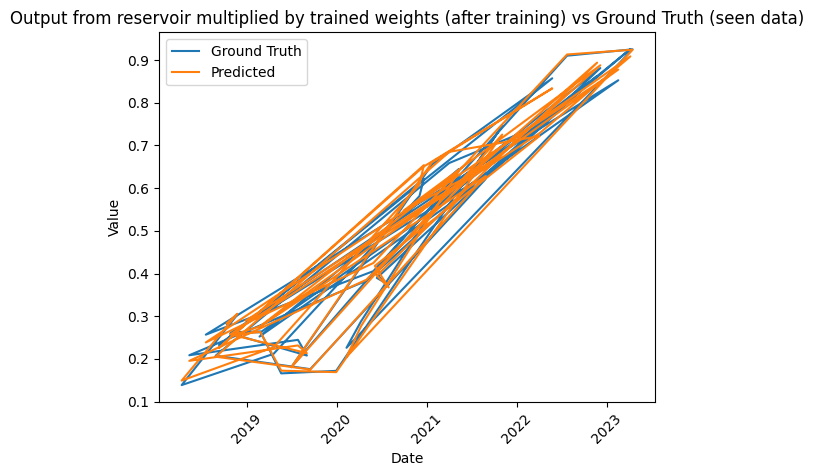

In [16]:
reservoir_preds, memory = QRC_predict(batched_history[100: 150], train = True)
y_pred = model.predict(reservoir_preds)
plt.plot(ground_truth_dates[100 : 150], ground_truth_values[100: 150])
plt.plot(ground_truth_dates[100 : 150], y_pred)
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation = 45)
plt.legend(['Ground Truth', 'Predicted'])
plt.title('Output from reservoir multiplied by trained weights (after training) vs Ground Truth (seen data)')
plt.show()

[0.83881484]
1 future value predicted... 49 more predictions to go.
[0.83847492]
[0.83636829]
[0.83492425]
[0.83815102]
[0.84328487]
[0.84372332]
[0.83815422]
[0.83699919]
[0.84337625]
10 future value predicted... 40 more predictions to go.
[0.8497977]
[0.84757503]
[0.84102887]
[0.84137999]
[0.85096754]
[0.85765092]
[0.85269033]
[0.8446673]
[0.8476177]
[0.86057981]
20 future value predicted... 30 more predictions to go.
[0.86630864]
[0.85731799]
[0.84812637]
[0.85490644]
[0.87159283]
[0.87493206]
[0.86097319]
[0.85139221]
[0.86365125]
[0.88399093]
30 future value predicted... 20 more predictions to go.
[0.88293158]
[0.863182]
[0.85445329]
[0.87423205]
[0.89768966]
[0.88974552]
[0.8637387]
[0.85753781]
[0.88707036]
[0.91219341]
40 future value predicted... 10 more predictions to go.
[0.89449394]
[0.86227038]
[0.86079973]
[0.90247047]
[0.92671208]
[0.89636238]
[0.85846348]
[0.86452805]
[0.92069316]
[0.9402324]
50 future value predicted... 0 more predictions to go.
Done.........


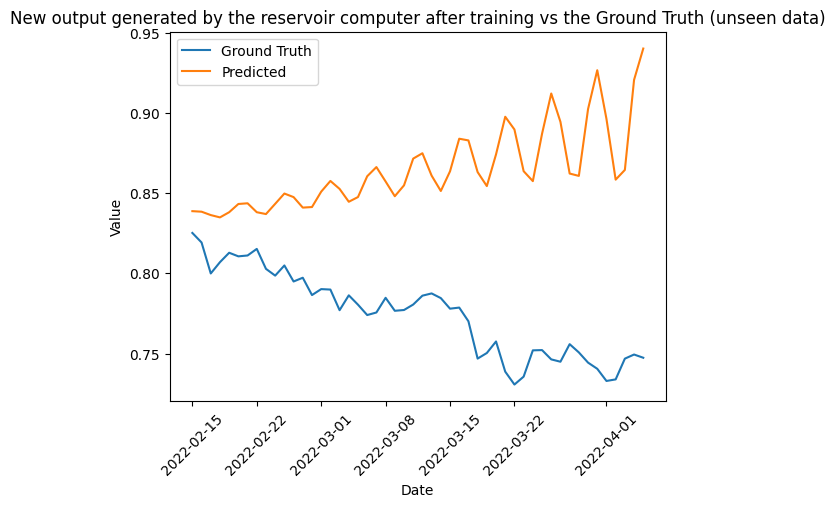

In [20]:
start = 1500
num = 50
y_pred = QRC_predict(X = history[start],
                    num_steps_in_future = num,
                    memory = None,
                    model = model,
                    train = False)
plt.plot(truth_dates[start : start + num], truth_values[start : start + num])
plt.plot(truth_dates[start : start + num], y_pred[0])
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation = 45)
plt.legend(['Ground Truth', 'Predicted'])
plt.title('New output generated by the reservoir computer after training vs the Ground Truth (unseen data)')
plt.show()

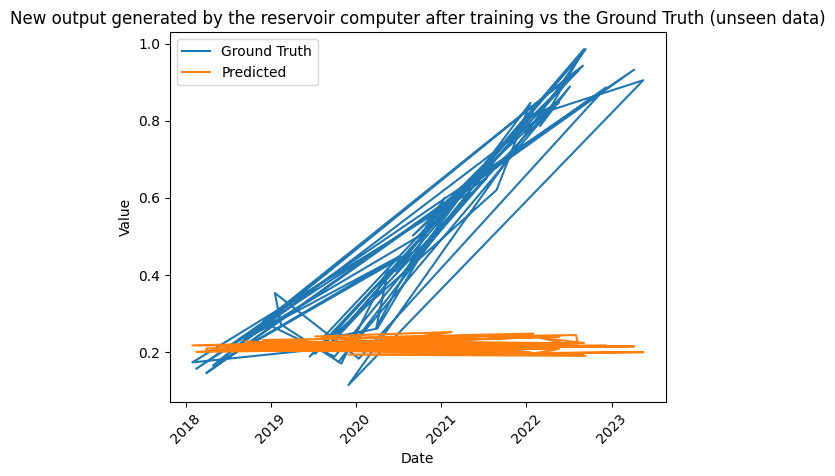

In [18]:
plt.plot(ground_truth_dates[150: 200], ground_truth_values[150: 200])
plt.plot(ground_truth_dates[150: 200], y_pred[0])
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation = 45)
plt.legend(['Ground Truth', 'Predicted'])
plt.title('New output generated by the reservoir computer after training vs the Ground Truth (unseen data)')
plt.show()

In [19]:
y_pred = []
initial_input = values[501]
for i in range(1000):
  print("Prediction {} done...".format(i))
  pred = model.predict([forward([initial_input])])
  y_pred.append(pred)
  initial_input = pred
  print(end = "\r")
print("R2 score: ", r2_score(values[501: 1501], y_pred))

Prediction 0 done...


NameError: ignored

In [ ]:
plt.plot(dates[500: 1500], values[500: 1500])
plt.plot(dates[500: 1500], y_pred)
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation = 45)
plt.legend(['Ground Truth', 'Predicted'])
plt.title('Synthetic time-series data')
plt.show()

In [ ]:
upper_triangular = np.array([[0, 2, 3],
                             [0, 0, 6],
                             [0, 0, 0]])

# Get the upper triangular elements (excluding diagonal)
upper_triangular_elements = upper_triangular[np.triu(np.ones(upper_triangular.shape), k=1).astype(bool)]

# Convert the upper triangular elements to a list
upper_triangular_list = upper_triangular_elements.tolist()
upper_triangular_list

In [ ]:
np.shuffle()

In [ ]:
def tune_spectral_radius(new_j_0 : int) -> np.ndarray:
  """
  Given a spectral radius value, it scales all the eigen values of the coupling matrix by this value,
  keeping the eigenvectors fixed.

  Parameters
  ----------

  new_j_0: New spectral radius

  Returns
  -------
  np.ndarray: The new coupling matrix

  """
  new_eigen_values = initial_eigen_values / initial_J_0
  new_eigen_values *= new_j_0

  return initial_eigen_vector_matrix @ np.diag(new_eigen_values) @ np.transpose(initial_eigen_vector_matrix)
